# Verifying a mixed finite element solver for the incompressible Navier-Stokes equations using FEniCS and the Method of Manufactured Solution.

This tutorial summarizes how to...
- solve the incompressible Navier-Stokes equations with mixed finite elements using FEniCS [1].
- write an extensible solver class using FEniCS.

and shows in more detail how to...
- verify a solver using the Method of Manufactured Solution (MMS) [2].
- compute empirical orders of convergence.

## Python packages

Use the FEniCS library to implement the solver and also for post-processing.

In [1]:
import fenics

Typically FEniCS users don't directly use UFL; but we will need one feature to apply MMS with vector-valued solutions.

In [2]:
from ufl import unit_vector

We have to do a bit of arithmetic to compute the empirical order of convergence.

In [3]:
from math import log

Though `fenics` has the built-in `fenics.plot`, we will do some more advanced plotting.

In [4]:
import matplotlib
%matplotlib inline

## The problem

Consider the strong form of the incompressible Navier-Stokes equations with known source terms.

\begin{align*} 
    \nabla\mathbf{u}\cdot\mathbf{u} + \nabla p - 2\mu \nabla \cdot \mathrm{sym}(\nabla\mathbf{u}) &= 0 \quad \\
    \nabla \cdot \mathbf{u} &= 0 \quad  \\
\end{align*}

Using mixed finite elements, we want to solve the variational problem: 
Find $\mathbf{u}, p \in \mathbf{V} \times V$ such that

\begin{align*}
    \mathcal{F} = 0 
    \quad \forall \boldsymbol{\psi}_u, \psi_p \in \mathbf{V} \times V
\end{align*}

where

\begin{align*}
    \mathcal{F} = (\boldsymbol{\psi}_u, \nabla\mathbf{u}\cdot\mathbf{u}) -(\nabla\cdot\boldsymbol{\psi}_u,p) + 2\mu(\mathrm{sym}(\nabla\boldsymbol{\psi}_u),\mathrm{sym}(\nabla\mathbf{u}))
    + (\psi_p,\nabla\cdot\mathbf{u})
\end{align*}

We choose the stable [3] Taylor-Hood (i.e. P2P1) element, providing a piecewise quadratic space $\mathbf{V}$ and piecewise linear space $V$.

|Note| 
|----|
|We denote integrating inner products over the domain as $(v,u) = \int_\Omega v u d \mathbf{x}$ or $(\mathbf{v},\mathbf{u}) = \int_\Omega \mathbf{v} \cdot \mathbf{u} d \mathbf{x}$.|

## The solver

The following class solves this variational problem for a general mesh, boundary conditions, and dynamic viscosity. The variational form is defined in its own method so that we can later easily extend it for verification via MMS. The focus of this tutorial is on MMS rather than the solver itself, so here we will skip over some details.

In [5]:
class IncompressibleNavierStokesSolver:
    
    def __init__(self, 
            mesh, boundary_condition_values, parameters):
        
        element = fenics.MixedElement([
            fenics.VectorElement('P', mesh.ufl_cell(), 2),
            fenics.FiniteElement('P', mesh.ufl_cell(), 1)])
        
        function_space = fenics.FunctionSpace(mesh, element)
        
        solution = fenics.Function(function_space)
        
        
        self.function_space = function_space
        
        self.solution = solution
        
        self.parameters = parameters
        
        
        class Boundaries(fenics.SubDomain):

            def inside(self, x, on_boundary):

                return on_boundary
                
        boundaries = Boundaries()
        
        bc_u = fenics.DirichletBC(
            function_space.sub(0),
            boundary_condition_values[0],
            boundaries)

        bc_p = fenics.DirichletBC(
            function_space.sub(1),
            boundary_condition_values[1],
            boundaries)
        
        boundary_conditions = [bc_u, bc_p]
        
        
        F = self.variational_form()
        
        problem = fenics.NonlinearVariationalProblem(
            F = F,
            u = solution,
            bcs = boundary_conditions,
            J = fenics.derivative(F, solution))
        
        fenics_solver = fenics.NonlinearVariationalSolver(problem)
        
        
        self.element = element
        
        self.fenics_solver = fenics_solver
        
        
        """ `self.fenics_solver` breaks 
        (presumably due to some kind of scoping issue)
        if we don't make `boundary_conditions` an attribute. """
        self.boundary_conditions = boundary_conditions
        
    def variational_form(self):
        
        mu = fenics.Constant(self.parameters["dynamic_viscosity"])
        
        inner, dot, grad, div, sym = \
            fenics.inner, fenics.dot, fenics.grad, fenics.div, fenics.sym
        
        u, p = fenics.split(self.solution)
        
        dot, grad, div, sym = fenics.dot, fenics.grad, fenics.div, fenics.sym
        
        
        psi_u, psi_p = fenics.TestFunctions(self.function_space)
        
        variational_form = (dot(psi_u, dot(grad(u), u))
            - div(psi_u)*p + 2.*mu*inner(sym(grad(psi_u)), sym(grad(u)))
            + psi_p*(div(u)))*fenics.dx
        
        return variational_form
    
    def solve(self):
        
        self.fenics_solver.solve()

## Verification via MMS

So that we can verify the solver via the Method for Manufactured Solution (MMS) [2], we extend* the PDE with arbitrary source terms.

\begin{align*} 
    \nabla\mathbf{u}\cdot\mathbf{u} + \nabla p - 2\mu \nabla \cdot \mathrm{sym}(\nabla\mathbf{u}) &= \mathbf{s}_u \quad \\
    \nabla \cdot \mathbf{u} &= s_p \quad  \\
\end{align*}

The extended variational form is then

\begin{align*}
    \mathcal{F} = (\boldsymbol{\psi}_u, \nabla\mathbf{u}\cdot\mathbf{u} - \mathbf{s}_u) -(\nabla\cdot\boldsymbol{\psi}_u,p) + 2\mu(\mathrm{sym}(\nabla\boldsymbol{\psi}_u),\mathrm{sym}(\nabla\mathbf{u}))
    + (\psi_p,\nabla\cdot\mathbf{u} - s_p)
\end{align*}

|Note| 
|----|
|* For many solvers, source terms already exist.|

Thanks to having already implemented an extensible solver class, we can implement these source terms with a few lines of code and without changing the original form.

In [6]:
class VerifiableSolver(IncompressibleNavierStokesSolver):
    
    def __init__(self, 
            mesh, boundary_condition_values, source_terms, parameters):
        
        self.source_terms = source_terms
        
        super().__init__(mesh, boundary_condition_values, parameters)
        
    def variational_form(self):
        
        F = super().variational_form()
        
        psi_u, psi_p = fenics.TestFunctions(self.function_space)
        
        s_u, s_p = self.source_terms
        
        dot = fenics.dot
        
        F -= (dot(psi_u, s_u) + psi_p*s_p)*fenics.dx
        
        return F

Manufacture a solution according to the guidelines in [3]. The syntax of `fenics` requires us to define this in terms of a mesh to access the spatial coordinates.

In [7]:
def manufactured_solution(mesh):
    
    sin, pi = fenics.sin, fenics.pi
    
    x, y = fenics.SpatialCoordinate(mesh)
    
    u_M = (sin(2.*pi*x)*sin(pi*y), sin(pi*x)*sin(2.*pi*y))
    
    p_M = -0.5*(u_M[0]**2 + u_M[1]**2)
    
    return u_M, p_M

Set the boundary conditions, which are equivalent to the manufactured solution.

In [8]:
""" We should be able to simply use u_M and p_M, 
but the interface to `fenics.DirichletBC` is proving troublesome.
For now we manufactured a solution with vanishing values on the boundary."""
boundary_condition_values = ((0., 0.), 0.)

Derive the source terms which will yield the manufactured solution
    by substituting the manufactured solution into the strong form.

In [9]:
def source_terms(u_M, p_M, dynamic_viscosity):
    
    grad, dot, div, sym = fenics.grad, fenics.dot, fenics.div, fenics.sym
    
    mu = dynamic_viscosity
    
    """ Working symbolically with the vector-valued solution in `fenics` 
    seems to require invocation of the cartesian unit vectors, 
    rather than using tuples or lists. """
    ihat, jhat = unit_vector(0, 2), unit_vector(1, 2)
    
    _u_M = u_M[0]*ihat + u_M[1]*jhat
    
    s_u = grad(_u_M)*_u_M + grad(p_M) - 2.*div(mu*sym(grad(_u_M)))
    
    s_p = div(_u_M)
    
    return s_u, s_p

Compute the L2 norm error based on the manufactured solution and the computed discrete solution.

In [10]:
def L2_error(solution):
    
    """ The `fenics.errornorm` interface seems to require that 
    we define a fenics.Expression using the C string representation, 
    rather than allowing us to reuse our already defined u_M, p_M. 
    This unfortunately requires us to again write the manufactured solution.
    Perhaps there is another approach where we could only write this once."""
    
    exact_u = ("sin(2.*pi*x[0])*sin(pi*x[1])", "sin(pi*x[0])*sin(2.*pi*x[1])")

    exact_p = "-0.5*(pow(" + exact_u[0] + ", 2) + pow(" + exact_u[1] + ", 2))"
    
    exact_solution = fenics.Expression(
        (exact_u[0], exact_u[1], exact_p), 
        element = solution.function_space().ufl_element())
    
    return fenics.errornorm(exact_solution, solution, "L2")

Define a function for plotting the solution.

In [11]:
def plot(solution):
    
    u, p = fenics.split(solution)

    for var, label in zip(
            (u, u[0], u[1], p),
            ("$\mathbf{u}$", "$u_0$", "$u_1$", "$p$")):

        colormap = fenics.plot(var)
        
        matplotlib.pyplot.colorbar(colormap)
        
        matplotlib.pyplot.title(label)
        
        matplotlib.pyplot.xlabel("$x$")
        
        matplotlib.pyplot.ylabel("$y$")
        
        matplotlib.pyplot.show()

Solve a series of problems with larger grids to verify the convergence order.

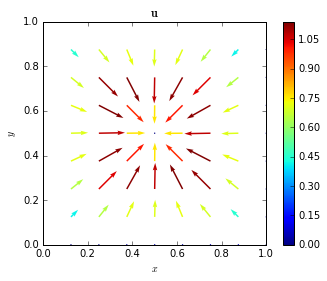

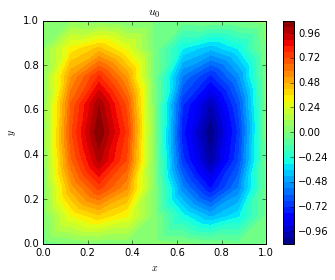

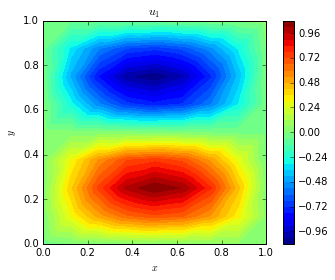

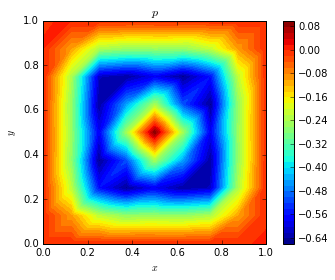

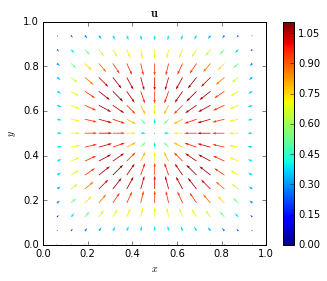

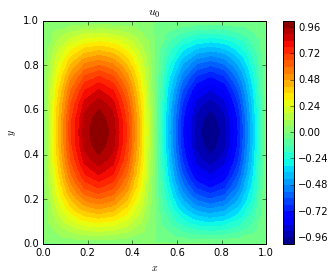

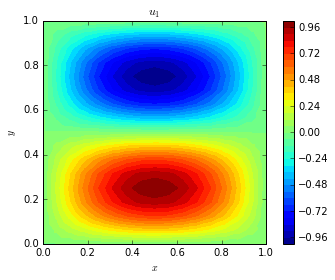

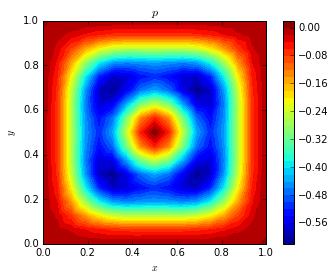

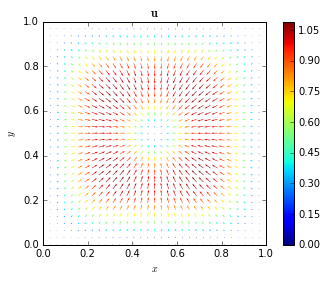

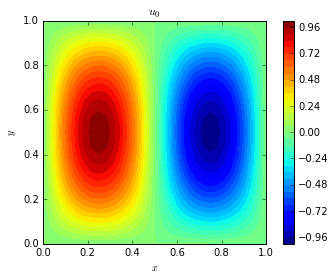

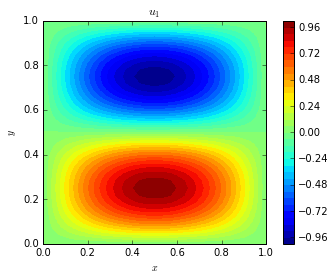

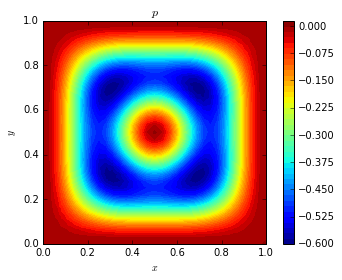

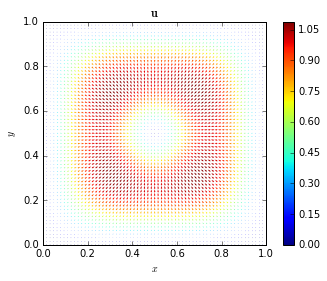

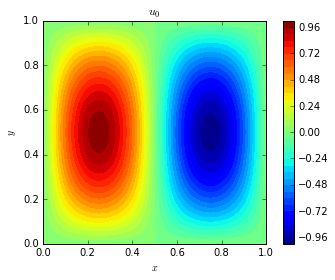

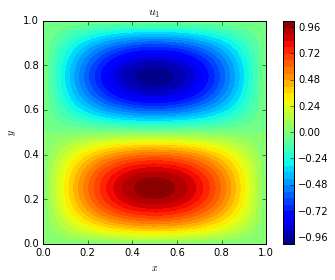

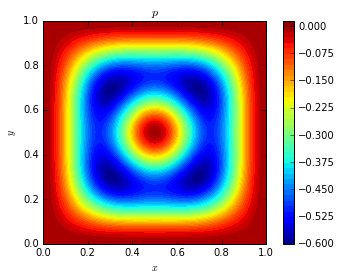

In [12]:
dynamic_viscosity = 0.01

grid_sizes = (8, 16, 32, 64)

L2_errors = []

for M in grid_sizes:
    
    mesh = fenics.UnitSquareMesh(M, M)
    
    u_M, p_M = manufactured_solution(mesh)
    
    s_u, s_p = source_terms(u_M, p_M, dynamic_viscosity)
    
    solver = VerifiableSolver(
        mesh = mesh,
        boundary_condition_values = boundary_condition_values,
        source_terms = (s_u, s_p),
        parameters = {"dynamic_viscosity": dynamic_viscosity})
    
    solver.solve()
    
    plot(solver.solution)
    
    L2_errors.append(L2_error(solver.solution))

Plot the L2 errors against the cell edge lengths with a log-log scale. Also print the computed empircal convergence order. We expect to see quadratic convergence.

Convergence order = 2.0394717840217127


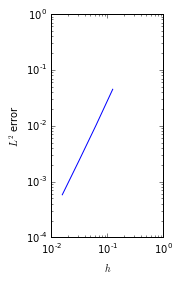

In [13]:
edge_lengths = [1./float(M) for M in grid_sizes]

matplotlib.pyplot.loglog(edge_lengths, L2_errors)

matplotlib.pyplot.xlabel("$h$")

matplotlib.pyplot.ylabel("$L^2$ error")

matplotlib.pyplot.axis("square")

e, h = L2_errors, edge_lengths

order = (log(e[-1]) - log(e[-2]))/(log(h[-1]) - log(h[-2]))

print("Convergence order = " + str(order))

## References
[1] A Logg, KA Mardal, and GN Wells. **Automated Solution of Differential Equations by the Finite Element Method**, *Springer*, 2012.

[2] K Salari and P Knupp. **Code verification by the method of manufactured solutions.**, *Sandia National Labs*, No. SAND2000-1444, 2000.

[3] J Donea and A Huerta. **Finite element methods for flow problems.** *John Wiley & Sons*, 2003. 